In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Any, Callable, Dict, Optional, Tuple, List
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree
import torchvision
import math
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageDraw, ImageFont
from PIL import Image
import cv2
import collections
import numpy as np
import os

In [2]:
dataset_path = "../../../../../../data/preprocessing/"
classes = ["grass","tree","nest"]

In [3]:
class MyDataset(Dataset):
    def __init__(self, dataset_path, dataset_type, transform=None):
        self.path = dataset_path
        if dataset_type == "train": self.dataset_type = "train/"
        elif dataset_type == "test": self.dataset_type = "test/"
        elif dataset_type == "val": self.dataset_type = "val/"
        else: print("[Error Message] : Please check datatype") 
        
        try:
            self.ann_root, self.ann_dir, self.ann_files = next(os.walk(os.path.join(self.path, self.dataset_type, "Annotations")))
            self.img_root, self.amg_dir, self.img_files = next(os.walk(os.path.join(self.path, self.dataset_type, "JPEGImages")))
            self.images = [os.path.join(self.img_root, x)for x in self.img_files]
            self.targets = [os.path.join(self.ann_root, x)for x in self.ann_files]
            self.images.sort()
            self.targets.sort()

        except AttributeError as e: print(e)
        except StopIteration as e: print("[Error Message] : please check data path")
        
        self.transform = transform
            
    def __len__(self):
        return len(self.ann_files)

    def __getitem__(self, index):
        # Function to get the data from XML Annotation
        image = cv2.imread(self.images[index], cv2.IMREAD_COLOR)
        b, g, r = cv2.split(image)   # img파일을 b,g,r로 분리
        image = cv2.merge([r, g, b])  # b, r을 바꿔서 Merge
        target = self.parse_voc_xml(Et.parse(self.targets[index]).getroot())  # xml파일 분석하여 dict으로 받아오기

        targets = []    # 바운딩 박스 좌표
        labels = []     # 바운딩 박스 클래스
        
        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])
            targets.append(list(map(int, label[:4])))
            labels.append(int(label[4]))

        return image, targets, labels
    
    # xml 파일을 dictionary로 반환
    def parse_voc_xml(self, node: Et.Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


In [4]:
train_ds = MyDataset(dataset_path, "train")
val_ds = MyDataset(dataset_path, "val")
test_ds = MyDataset(dataset_path, "test")
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
print(test_ds[0])

5974
312
417
(array([[[ 75,  98,  26],
        [ 90, 117,  40],
        [101, 133,  50],
        ...,
        [171, 152, 135],
        [183, 164, 147],
        [179, 160, 143]],

       [[104, 126,  54],
        [109, 135,  61],
        [ 75, 107,  22],
        ...,
        [165, 146, 129],
        [182, 163, 146],
        [177, 158, 141]],

       [[116, 136,  67],
        [117, 141,  67],
        [105, 134,  50],
        ...,
        [178, 159, 142],
        [183, 164, 147],
        [159, 140, 123]],

       ...,

       [[164, 152, 138],
        [159, 145, 132],
        [132, 116, 103],
        ...,
        [163, 153, 143],
        [149, 139, 129],
        [163, 153, 143]],

       [[147, 135, 123],
        [131, 117, 106],
        [116,  99,  89],
        ...,
        [168, 158, 148],
        [160, 150, 140],
        [164, 154, 144]],

       [[122, 110,  98],
        [111,  97,  86],
        [111,  94,  86],
        ...,
        [156, 146, 136],
        [160, 150, 140],
        [1

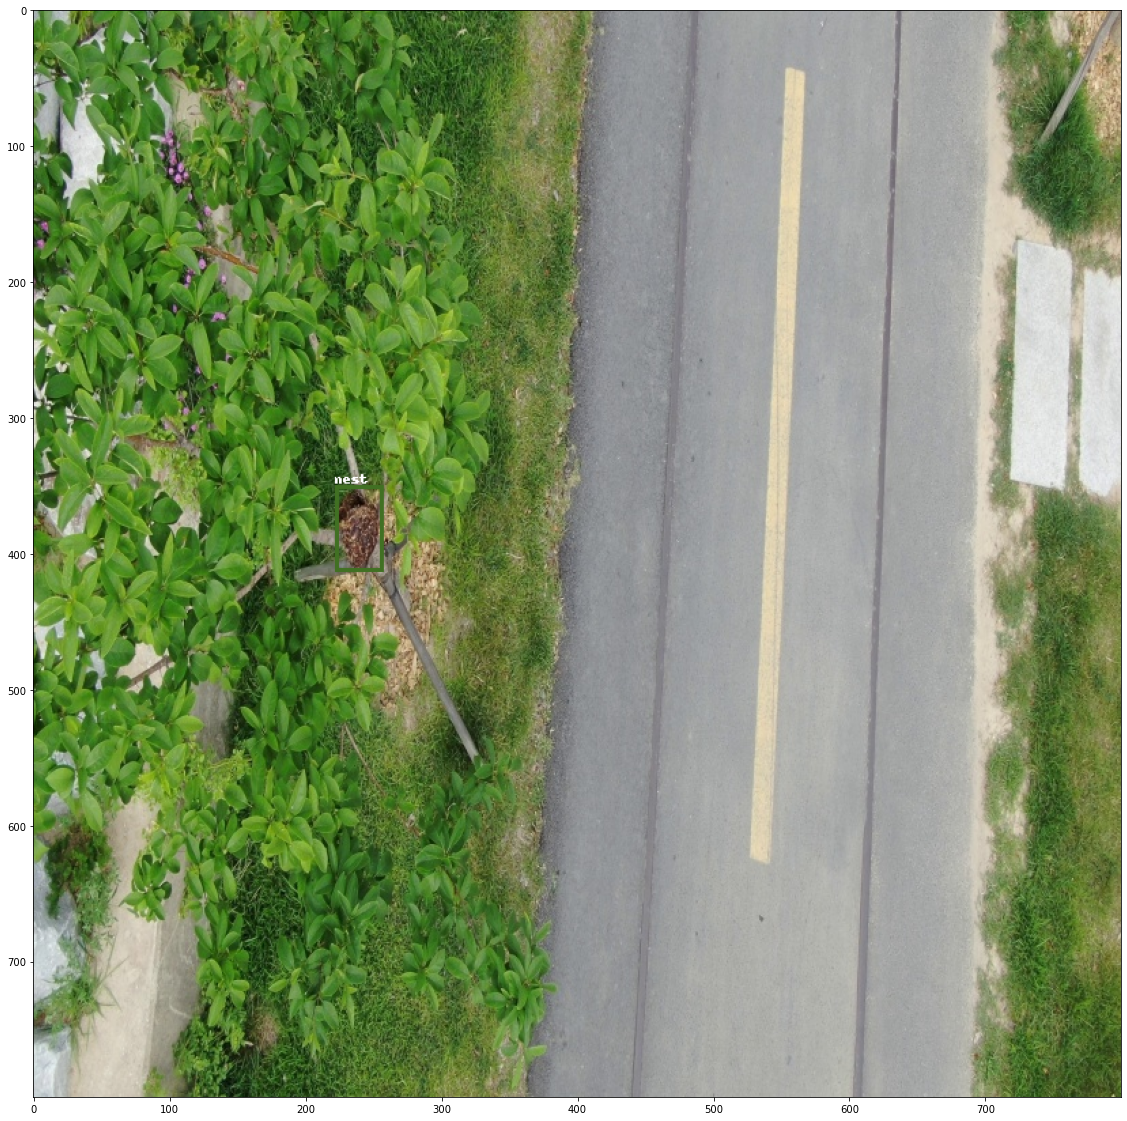

In [5]:
# 샘플 이미지 확인
img, target, label = val_ds[-1]
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')  # 바운딩 박스 색상

# 시각화 함수


def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg, label in zip(targets, labels):
        id_ = int(label)  # class
        bbox = tg[:4]    # [x1, y1, x2, y2]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])),outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]-10), name, fill=(255, 255, 255, 0))
        
    plt.imshow(np.array(img))


plt.figure(figsize=(20, 20))
show(img, target, label)

In [6]:
train_dl = DataLoader(train_ds, batch_size=4,shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True)

In [7]:
print(len(train_dl))
print(len(val_dl))

1494
78


In [11]:
for tensor_img,xy,label in train_dl:
    print(f"tensor_img_shape : {tensor_img.shape}\n")
    print(f"xy : {xy}\n")
    print(f"label : {label}\n")
    break

tensor_img_shape : torch.Size([4, 800, 800, 3])

xy : [[tensor([374, 614, 460, 618]), tensor([702, 555, 148, 496]), tensor([425, 656, 492, 705]), tensor([767, 630, 202, 663])]]

label : [tensor([2, 2, 2, 2])]

